# Reconstruction of plant--pollinator networks from observational data 

A tutorial on how to use our [Stan](http://mc-stan.org) model to infer the structure and properties of real ecosystems from noisy, error-prone measurements.
Based on the article [*"Reconstruction of plant--pollinator networks from observational data"*](https://www.biorxiv.org/content/10.1101/754077v1), by [J.-G. Young](http://jgyoung.ca), [F. S. Valdovinos](https://www.fsvaldovinos.com/) and [M.E.J. Newman](http://www-personal.umich.edu/~mejn/).

A data analysis for 
"The Effects of Goatgrass Removal on Grassland Plant-Pollinator Interactions" by R. Nelson, S. Dritz, F. Valdovinos, & P. Aigner


*Authors*: J.-G. Young <jgyou@umich.edu> S. Dritz <sjdritz@ucdavis.edu> R. A. Nelson , <ranelson@ucdavis.edu> <br/>
*Date*: April 2022 <br/>

---

**Important Note:** In this notebook, I assume that you have installed `pystan` and will interact with the model in `python3` (check the [README](README.md) file otherwise). `Stan` also has a [R interface](https://cran.r-project.org/web/packages/rstan/index.html), for which we do not provide helper functions.
That said, all what we show here should easily be transferable to the `R` version of `Stan`!
The only purpose of our python code is to manipulate the samples once they have been generated by `Stan`.

---

## Loading data and modules

First, let's import some required modules: 'pystan `numpy` and `pyplot` to handle the model the data and visualize our results.
We'll also import the custom helper modules `utilities` (load / save / compress / sort data matrices) and `plant_pol_inference` (interact with model, draw samples, compute estimates).

In [1]:
import sys
!{sys.executable} -m pip install texttable

In [2]:
import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
%matplotlib inline  
import utilities as ut
import plant_pol_inference_pystan3 as pp
import greedySolver2
import toolbox
import nest_asyncio
nest_asyncio.apply()
del nest_asyncio


We'll use the data matrix shown in the paper as an example. 
It comes from the Supplementary information of [this paper by Kaiser-Bunbury et al. [Nature **542**, 2017]](https://www.nature.com/articles/nature21071). It records the number of interactions between 8 plant species and 21 pollinator species. This is for a single ecosystem, as observed over the course of one month.

In [3]:
C = np.loadtxt('control_network.txt').astype('int')
C = ut.sort(C, C)
c_p = C.shape[0]
c_a = C.shape[1]

R = np.loadtxt('restored_network.txt').astype('int')
R = ut.sort(R, R)
r_p = R.shape[0]
r_a = R.shape[1]

Let's visualize it:

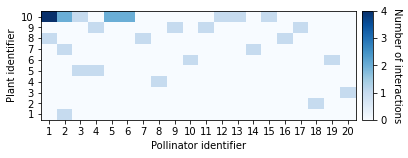

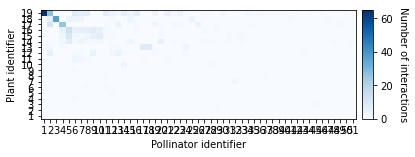

In [4]:
#control
plt.figure(figsize=(6,2))
plt.pcolormesh(C, cmap=plt.cm.Blues)
cb= plt.colorbar(fraction=0.04, pad=0.02, aspect=10)
cb.ax.get_yaxis().labelpad = 15
cb.set_label('Number of interactions', rotation=270)
plt.yticks(np.array(range(c_p)) + 0.5, range(1, c_p + 1))
plt.xticks(np.array(range(c_a)) + 0.5, range(1, c_a + 1))
plt.xlabel('Pollinator identifier');
plt.ylabel('Plant identifier');

#restored
plt.figure(figsize=(6,2))
plt.pcolormesh(R, cmap=plt.cm.Blues)
cb= plt.colorbar(fraction=0.04, pad=0.02, aspect=10)
cb.ax.get_yaxis().labelpad = 15
cb.set_label('Number of interactions', rotation=270)
plt.yticks(np.array(range(r_p)) + 0.5, range(1, r_p + 1))
plt.xticks(np.array(range(r_a)) + 0.5, range(1, r_a + 1))
plt.xlabel('Pollinator identifier');
plt.ylabel('Plant identifier');

## Pystan model

In `pystan`, we write the statistical model in a separate file.
In our case, it looks like:

In [5]:
with open('model_pystan3.stan', 'r') as f:
    print(f.read())

data {
  // Dimensions of the data matrix, and matrix itself.
  int<lower=1> n_p;
  int<lower=1> n_a;
  array[n_p, n_a] int<lower=0> M;
}
transformed data {
  // Pre-compute the marginals of M to save computation in the model loop.
  array[n_p] int M_rows = rep_array(0, n_p);
  array[n_a] int M_cols = rep_array(0, n_a);
  int M_tot = 0;
  for (i in 1:n_p) {
    for (j in 1:n_a) {
      M_rows[i] += M[i, j];
      M_cols[j] += M[i, j];
      M_tot += M[i, j];
    }
  }
}
parameters {
  real<lower=0> C;
  real<lower=0> r;
  simplex[n_p] sigma;
  simplex[n_a] tau;
  real<lower=0, upper=1> rho;
}
model {
  // Priors
  r ~ exponential(0.01);
  rho ~ normal(0.25, 0.1);

  // Global sums and parameters
  target += M_tot * log(C) - C;
  // Weighted marginals of the data matrix 
  for (i in 1:n_p) {
    target += M_rows[i] * log(sigma[i]);
  }
  for (j in 1:n_a) {
    target += M_cols[j] * log(tau[j]);
  }
  // Pairwise loop
  for (i in 1:n_p) {
    for (j in 1:n_a) {
      real nu_ij_0 = log(1

The `data` block contains the model parameters, in our case the dimension of the observation matrix, and the matrix itself.

The `transformed data` block allows us to calculate quantities that we'll use later. Here, we calculate the row and column sums of M, as well as its total sum.

The `parameter` block contains... well.. the parameters of the model.
These parameters are the ones that will be sampled by `Stan`, and returned to us  once we run the program.
`sigma` and `tau` are of the "simplex" type---just a synonym for normalized distributions.

The `model` block calculates the log-posterior of the model. We accumulate this value in the variable `target`.

The `generated quantities` block contains other quantities, functions of the sampled parameters, that will be returned to us once we run the program. In this case, we generate the matrix Q of edge probabilities given the parameters.

---

## Compiling the model

To  start using the model, we first need to "compile" it.
During compilation, `pystan` builds an executable whose purpose is to generate samples from our model, given an input.

Our module `plant_pol_inference` (imported as `pp`) provides utilities to handle this.

In [6]:
#%%capture
model_c = pp.compile_stan_model(C, random_seed = 1); #control network
model_r = pp.compile_stan_model(R, random_seed = 1); #restored network

Building: found in cache, done.
Messages from stanc:
Warning in '/var/folders/dz/887wb7q155d3pyd6qzhg8hrm0000gn/T/httpstan_5qfsp883/model_u7varadm.stan', line 46, column 6: A
    control flow statement depends on parameter(s): C, r, rho, sigma, tau.
Warning in '/var/folders/dz/887wb7q155d3pyd6qzhg8hrm0000gn/T/httpstan_5qfsp883/model_u7varadm.stan', line 29, column 18: Argument
    0.01 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Building: found in cache, done.
Messages from stanc:
Warning in '/var/folders/dz/887wb7q155d3pyd6qzhg8hrm0000gn/T/httpstan_5qfsp883/model_u7varadm.stan', line 46, column 6: A
    control flow statement depends on parameter(s): C, r, rho, sigma, tau.
Warning in '/var/folders/dz/887wb7q155d3pyd6qzhg8hrm0000gn/T/httpstan_5qfsp883/model_u7varadm.stan', line 29, column 18: Argument
    0.01 suggests there may be parameters that are not unit scale; consider
    rescaling with a multipl

[Compiling]
[Compiling]


## Sampling

With the model compiled, we are ready to generate our first samples.

Our `plant_pol_inference` module also provide utilities that handle this.

In [7]:
samples_c = pp.generate_sample(model_c, num_chains = 4, num_warmup=2000, num_samples=10000) #sample control
#while not pp.test_samples(samples_c, tol = 0.05):
#    model_c = pp.compile_stan_model(C)
#    samples_c = pp.generate_sample(model_c, num_chains = 4, num_warmup=2000, num_samples=10000) #sample control
    
samples_r = pp.generate_sample(model_r, num_chains = 4, num_warmup=2000, num_samples=10000) #sample restored
#while not pp.test_samples(samples_r, tol = 0.05):
#    model_r = pp.compile_stan_model(R)
#    samples_r = pp.generate_sample(model_r, num_chains = 4, num_warmup=2000, num_samples=10000) #sample restored


Sampling:   0%
Sampling:   0% (1/48000)
Sampling:   0% (101/48000)
Sampling:   0% (201/48000)
Sampling:   1% (301/48000)
Sampling:   1% (500/48000)
Sampling:   1% (600/48000)
Sampling:   1% (700/48000)
Sampling:   2% (800/48000)
Sampling:   2% (900/48000)
Sampling:   2% (1100/48000)
Sampling:   2% (1200/48000)
Sampling:   3% (1300/48000)
Sampling:   3% (1500/48000)
Sampling:   3% (1600/48000)
Sampling:   4% (1800/48000)
Sampling:   4% (2000/48000)
Sampling:   4% (2100/48000)
Sampling:   5% (2300/48000)
Sampling:   5% (2500/48000)
Sampling:   6% (2700/48000)
Sampling:   6% (2900/48000)
Sampling:   6% (3100/48000)
Sampling:   7% (3200/48000)
Sampling:   7% (3300/48000)
Sampling:   7% (3400/48000)
Sampling:   7% (3500/48000)
Sampling:   8% (3700/48000)
Sampling:   8% (3900/48000)
Sampling:   9% (4100/48000)
Sampling:   9% (4300/48000)
Sampling:   9% (4500/48000)
Sampling:  10% (4700/48000)
Sampling:  10% (4900/48000)
Sampling:  11% (5200/48000)
Sampling:  11% (5500/48000)
Sampling:  12% (

Sampling:  47% (22600/48000)
Sampling:  47% (22700/48000)
Sampling:  48% (22800/48000)
Sampling:  48% (22900/48000)
Sampling:  48% (23100/48000)
Sampling:  48% (23200/48000)
Sampling:  49% (23300/48000)
Sampling:  49% (23500/48000)
Sampling:  49% (23600/48000)
Sampling:  50% (23800/48000)
Sampling:  50% (24000/48000)
Sampling:  50% (24100/48000)
Sampling:  50% (24200/48000)
Sampling:  51% (24400/48000)
Sampling:  51% (24500/48000)
Sampling:  51% (24700/48000)
Sampling:  52% (24800/48000)
Sampling:  52% (24900/48000)
Sampling:  52% (25000/48000)
Sampling:  52% (25100/48000)
Sampling:  52% (25200/48000)
Sampling:  53% (25300/48000)
Sampling:  53% (25400/48000)
Sampling:  53% (25600/48000)
Sampling:  54% (25700/48000)
Sampling:  54% (25900/48000)
Sampling:  54% (26100/48000)
Sampling:  55% (26200/48000)
Sampling:  55% (26400/48000)
Sampling:  55% (26500/48000)
Sampling:  56% (26900/48000)
Sampling:  56% (27100/48000)
Sampling:  57% (27200/48000)
Sampling:  57% (27500/48000)
Sampling:  58%

We can see by plotting the value of the posterior distribution, evaluated for each samples, that at least one chain has gotten stuck in a minima.

Note that in this plot, vertical lines separate Markov chains: All samples between two of these lines are generated sequentially, by an independent chain.

In [8]:
#CONTROL CHAIN CHECK

Text(0, 0.5, 'log posterior of rho')

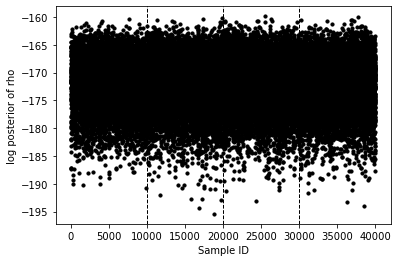

In [9]:
# re-sort restored network data so that it can be easiliy visualized by chain
chains = list(range(4)) * 10000
log_probs = np.column_stack((chains, samples_c['lp__'][0]))
log_probs = log_probs[log_probs[:,0].argsort()]

# plot it
plt.scatter(range(40000), log_probs[:,1], s=10, c='k')
for sep in [10000, 20000, 30000]:
    plt.axvline(sep, c='k', ls='--', lw=1)
plt.xlabel('Sample ID')
plt.ylabel('log posterior of rho')

Text(0, 0.5, 'C')

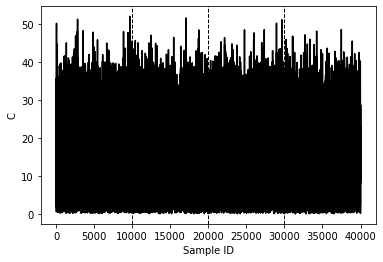

In [10]:
# re-sort restored network data so that it can be easiliy visualized by chain
chains = list(range(4)) * 10000
log_probs = np.column_stack((chains, samples_c['C'][0]))
log_probs = log_probs[log_probs[:,0].argsort()]

# plot it
plt.plot(range(40000), log_probs[:,1], c='k')
for sep in [10000, 20000, 30000]:
    plt.axvline(sep, c='k', ls='--', lw=1)
plt.xlabel('Sample ID')
plt.ylabel('C')

Text(0, 0.5, 'r')

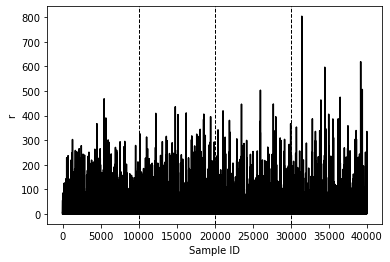

In [11]:
# re-sort restored network data so that it can be easiliy visualized by chain
chains = list(range(4)) * 10000
log_probs = np.column_stack((chains, samples_c['r'][0]))
log_probs = log_probs[log_probs[:,0].argsort()]

# plot it
plt.plot(range(40000), log_probs[:,1], c='k')
for sep in [10000, 20000, 30000]:
    plt.axvline(sep, c='k', ls='--', lw=1)
plt.xlabel('Sample ID')
plt.ylabel('r')

Text(0, 0.5, 'rho')

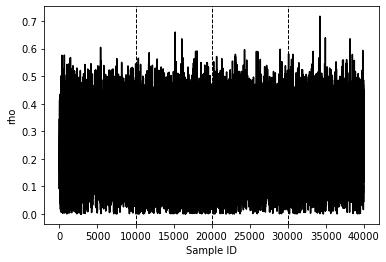

In [12]:
# re-sort restored network data so that it can be easiliy visualized by chain
chains = list(range(4)) * 10000
log_probs = np.column_stack((chains, samples_c['rho'][0]))
log_probs = log_probs[log_probs[:,0].argsort()]

# plot it
plt.plot(range(40000), log_probs[:,1], c='k')
for sep in [10000, 20000, 30000]:
    plt.axvline(sep, c='k', ls='--', lw=1)
plt.xlabel('Sample ID')
plt.ylabel('rho')

In [13]:
# checking whether any chain got caught in a local minima
tol = 0.05
num_chains = 4
log_probs = samples_c['lp__'][0]
n = len(log_probs) // num_chains  # number of samples per chain
log_probs = [log_probs[list(range(i, n - (num_chains - i), num_chains))] for i in range(num_chains)]
log_probs_means = np.array([np.mean(lp) for lp in log_probs])

print("[Average Log-Probability Per Chain]")
print(log_probs_means)

print((abs(log_probs_means) - (1 - tol) * max(abs(log_probs_means)) > 0))

[Average Log-Probability Per Chain]
[-172.0447328  -171.76973632 -171.88287136 -172.0552108 ]
[ True  True  True  True]


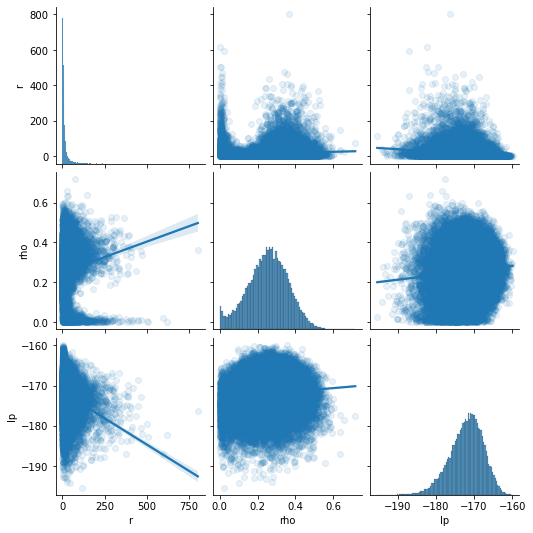

In [14]:
data = {'r': samples_c['r'][0], 'rho': samples_c['rho'][0], 'lp': samples_c['lp__'][0]}
df = pd.DataFrame(data)
seaborn.pairplot(df, kind='reg', plot_kws={'scatter_kws': {'alpha': 0.1}})

In [15]:
#RESTORED CHAIN CHECK

Text(0, 0.5, 'log posterior of rho')

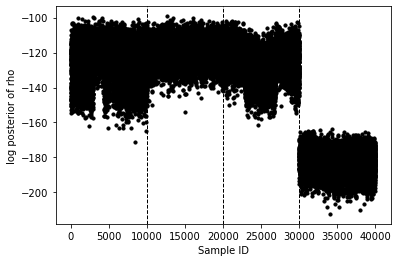

In [16]:
# re-sort restored network data so that it can be easiliy visualized by chain
chains = list(range(4)) * 10000
log_probs = np.column_stack((chains, samples_r['lp__'][0]))
log_probs = log_probs[log_probs[:,0].argsort()]

# plot it
plt.scatter(range(40000), log_probs[:,1], s=10, c='k')
for sep in [10000, 20000, 30000]:
    plt.axvline(sep, c='k', ls='--', lw=1)
plt.xlabel('Sample ID')
plt.ylabel('log posterior of rho')

Text(0, 0.5, 'C')

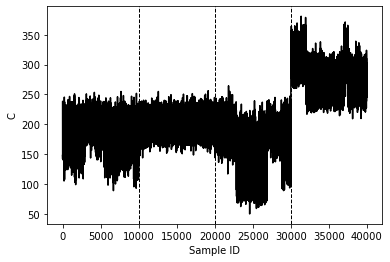

In [17]:
# re-sort restored network data so that it can be easiliy visualized by chain
chains = list(range(4)) * 10000
log_probs = np.column_stack((chains, samples_r['C'][0]))
log_probs = log_probs[log_probs[:,0].argsort()]

# plot it
plt.plot(range(40000), log_probs[:,1], c='k')
for sep in [10000, 20000, 30000]:
    plt.axvline(sep, c='k', ls='--', lw=1)
plt.xlabel('Sample ID')
plt.ylabel('C')

Text(0, 0.5, 'r')

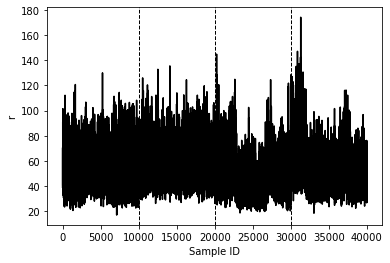

In [18]:
# re-sort restored network data so that it can be easiliy visualized by chain
chains = list(range(4)) * 10000
log_probs = np.column_stack((chains, samples_r['r'][0]))
log_probs = log_probs[log_probs[:,0].argsort()]

# plot it
plt.plot(range(40000), log_probs[:,1], c='k')
for sep in [10000, 20000, 30000]:
    plt.axvline(sep, c='k', ls='--', lw=1)
plt.xlabel('Sample ID')
plt.ylabel('r')

Text(0, 0.5, 'rho')

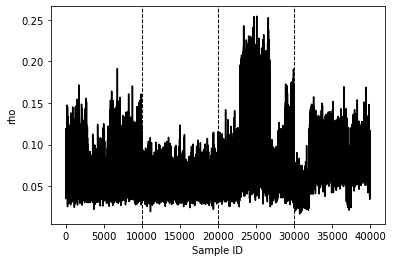

In [19]:
# re-sort restored network data so that it can be easiliy visualized by chain
chains = list(range(4)) * 10000
log_probs = np.column_stack((chains, samples_r['rho'][0]))
log_probs = log_probs[log_probs[:,0].argsort()]

# plot it
plt.plot(range(40000), log_probs[:,1], c='k')
for sep in [10000, 20000, 30000]:
    plt.axvline(sep, c='k', ls='--', lw=1)
plt.xlabel('Sample ID')
plt.ylabel('rho')

In [20]:
# checking whether any chain got caught in a local minima
tol = 0.05
num_chains = 4
log_probs = samples_r['lp__'][0]
n = len(log_probs) // num_chains  # number of samples per chain
log_probs = [log_probs[list(range(i, n - (num_chains - i), num_chains))] for i in range(num_chains)]
log_probs_means = np.array([np.mean(lp) for lp in log_probs])

print("[Average Log-Probability Per Chain]")
print(log_probs_means)

print((abs(log_probs_means) - (1 - tol) * max(abs(log_probs_means)) > 0))

[Average Log-Probability Per Chain]
[-140.67419231 -119.22405919 -136.1739775  -183.85572704]
[False False False  True]


## Posterior-predictive check

We provide a simple function that calculates the posterior predictive matrix.

In [21]:
C_tilde = pp.get_posterior_predictive_matrix(samples_c)
R_tilde = pp.get_posterior_predictive_matrix(samples_r)

Let's compare it with the input

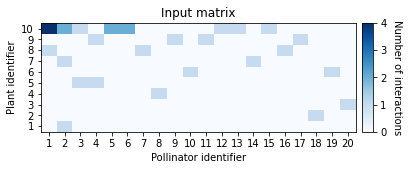

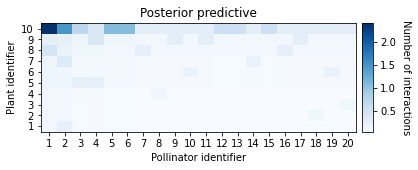

In [22]:
#Control

plt.figure(figsize=(6,2))
plt.title('Input matrix')
plt.pcolormesh(C, cmap=plt.cm.Blues)
cb= plt.colorbar(fraction=0.04, pad=0.02, aspect=10)
cb.ax.get_yaxis().labelpad = 15
cb.set_label('Number of interactions', rotation=270)
plt.yticks(np.array(range(c_p)) + 0.5, range(1, c_p + 1))
plt.xticks(np.array(range(c_a)) + 0.5, range(1, c_a + 1))
plt.xlabel('Pollinator identifier');
plt.ylabel('Plant identifier');
plt.figure(figsize=(6,2))
plt.title('Posterior predictive')
plt.pcolormesh(C_tilde, cmap=plt.cm.Blues)
cb= plt.colorbar(fraction=0.04, pad=0.02, aspect=10)
cb.ax.get_yaxis().labelpad = 15
cb.set_label('Number of interactions', rotation=270)
plt.yticks(np.array(range(c_p)) + 0.5, range(1, c_p + 1))
plt.xticks(np.array(range(c_a)) + 0.5, range(1, c_a + 1))
plt.xlabel('Pollinator identifier');
plt.ylabel('Plant identifier');


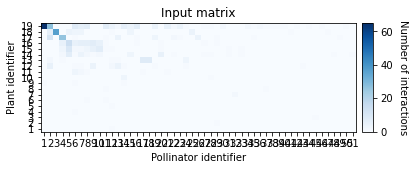

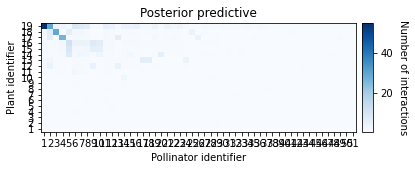

In [23]:
#Restored 

plt.figure(figsize=(6,2))
plt.title('Input matrix')
plt.pcolormesh(R, cmap=plt.cm.Blues)
cb= plt.colorbar(fraction=0.04, pad=0.02, aspect=10)
cb.ax.get_yaxis().labelpad = 15
cb.set_label('Number of interactions', rotation=270)
plt.yticks(np.array(range(r_p)) + 0.5, range(1, r_p + 1))
plt.xticks(np.array(range(r_a)) + 0.5, range(1, r_a + 1))
plt.xlabel('Pollinator identifier');
plt.ylabel('Plant identifier');
plt.figure(figsize=(6,2))
plt.title('Posterior predictive')
plt.pcolormesh(R_tilde, cmap=plt.cm.Blues)
cb= plt.colorbar(fraction=0.04, pad=0.02, aspect=10)
cb.ax.get_yaxis().labelpad = 15
cb.set_label('Number of interactions', rotation=270)
plt.yticks(np.array(range(r_p)) + 0.5, range(1, r_p + 1))
plt.xticks(np.array(range(r_a)) + 0.5, range(1, r_a + 1))
plt.xlabel('Pollinator identifier');
plt.ylabel('Plant identifier');

They are quite close!

More systematically we can check the distribution of the differences between the posterior predictive and the input:

Text(0, 0.5, 'Count')

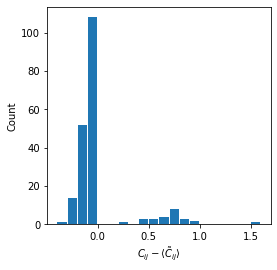

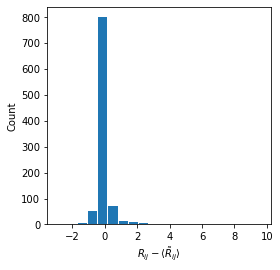

In [24]:
# Control
plt.figure(figsize=(4,4))
plt.hist((C-C_tilde).flatten(), density=False, bins=20, rwidth=0.9);

plt.xlabel(r'$C_{ij}-\langle \tilde{C}_{ij}\rangle$')
plt.ylabel('Count')

# Restored
plt.figure(figsize=(4,4))
plt.hist((R-R_tilde).flatten(), density=False, bins=20, rwidth=0.9);

plt.xlabel(r'$R_{ij}-\langle \tilde{R}_{ij}\rangle$')
plt.ylabel('Count')

Or compare the posterior predictive value to the input directly:

(-4.9, 38.0)

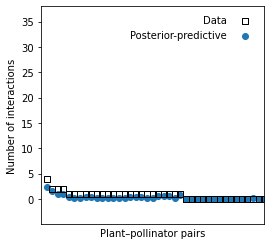

In [25]:
# Control

plt.figure(figsize=(4,4))
sort_order = np.argsort(-C.flatten())

plt.scatter(range(1, len(sort_order)+1), C.flatten()[sort_order], marker='s', facecolors='none', edgecolors='k', label='Data')
plt.scatter(range(1, len(sort_order)+1), C_tilde.flatten()[sort_order], label='Posterior-predictive', zorder=-10)

plt.xlim(0,40)
plt.xlabel('Plant–pollinator pairs')
plt.xticks([])
plt.ylabel(r'Number of interactions')
plt.legend(frameon=False, markerfirst=False, loc=1)
plt.ylim(-4.9,38)

(-4.9, 38.0)

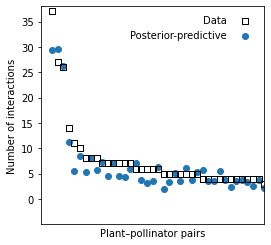

In [26]:
# Restored

plt.figure(figsize=(4,4))
sort_order = np.argsort(-R.flatten())

plt.scatter(range(1, len(sort_order)+1), R.flatten()[sort_order], marker='s', facecolors='none', edgecolors='k', label='Data')
plt.scatter(range(1, len(sort_order)+1), R_tilde.flatten()[sort_order], label='Posterior-predictive', zorder=-10)

plt.xlim(0,40)
plt.xlabel('Plant–pollinator pairs')
plt.xticks([])
plt.ylabel(r'Number of interactions')
plt.legend(frameon=False, markerfirst=False, loc=1)
plt.ylim(-4.9,38)

All these point of view confirm one thing: The model fits well.

Which means we're ready to calculate some estimates.

## Estimates

We provide a simple function to get the network estimate:

In [27]:
edge_prob_c = pp.estimate_network(samples_c)
np.savetxt('c_net_edge_probs.csv', edge_prob_c, delimiter = ',')

edge_prob_r = pp.estimate_network(samples_r)
np.savetxt('r_net_edge_probs.csv', edge_prob_r, delimiter = ',')

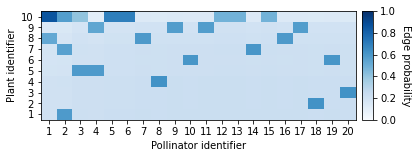

In [28]:
#control

plt.figure(figsize=(6,2))

plt.pcolormesh(edge_prob_c, cmap=plt.cm.Blues, vmin=0, vmax=1)
cb= plt.colorbar(fraction=0.04, pad=0.02, aspect=10)
cb.ax.get_yaxis().labelpad = 15
cb.set_label('Edge probability', rotation=270)
plt.yticks(np.array(range(c_p)) + 0.5, range(1, c_p + 1))
plt.xticks(np.array(range(c_a)) + 0.5, range(1, c_a + 1))
plt.xlabel('Pollinator identifier');
plt.ylabel('Plant identifier');


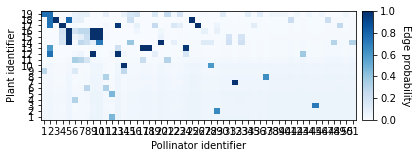

In [29]:
#restored

plt.figure(figsize=(6,2))

plt.pcolormesh(edge_prob_r, cmap=plt.cm.Blues, vmin=0, vmax=1)
cb= plt.colorbar(fraction=0.04, pad=0.02, aspect=10)
cb.ax.get_yaxis().labelpad = 15
cb.set_label('Edge probability', rotation=270)
plt.yticks(np.array(range(r_p)) + 0.5, range(1, r_p + 1))
plt.xticks(np.array(range(r_a)) + 0.5, range(1, r_a + 1))
plt.xlabel('Pollinator identifier');
plt.ylabel('Plant identifier');

The parameters themselves are contained in the `samples` object:

In [30]:
samples_c['rho']
samples_r['rho']

array([[0.08624038, 0.05194424, 0.09896931, ..., 0.04139058, 0.12308074,
        0.05666738]])

So we can, for example, visualize posterior distributions as:

Text(0, 0.5, 'Count')

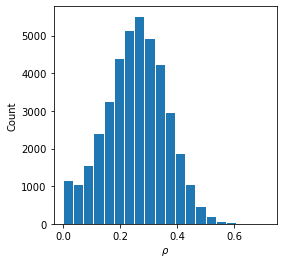

In [31]:
# control

plt.figure(figsize=(4,4))
plt.hist(samples_c['rho'][0], density=False, bins=20, rwidth=0.9);

plt.xlabel(r'$\rho$')
plt.ylabel('Count')

(0.0, 100.0)

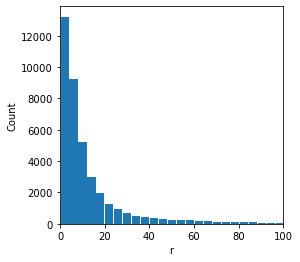

In [32]:
# control

plt.figure(figsize=(4,4))
plt.hist(samples_c['r'][0], density=False, bins=200, rwidth=0.9);

plt.xlabel('r')
plt.ylabel('Count')
plt.xlim(0, 100)

Text(0, 0.5, 'Count')

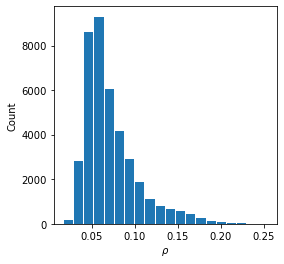

In [33]:
# restored

plt.figure(figsize=(4,4))
plt.hist(samples_r['rho'][0], density=False, bins=20, rwidth=0.9);

plt.xlabel(r'$\rho$')
plt.ylabel('Count')

(0.0, 100.0)

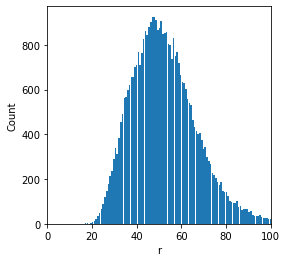

In [34]:
# restored

plt.figure(figsize=(4,4))
plt.hist(samples_r['r'][0], density=False, bins=200, rwidth=0.9);

plt.xlabel('r')
plt.ylabel('Count')
plt.xlim(0, 100)

And find posterior averages with:

In [35]:
print('Posterior average of the connectance:', np.mean(samples_c['rho'][0], axis=0))
print('Posterior average of the connectance:', np.mean(samples_r['rho'][0], axis=0))

Posterior average of the connectance: 0.25451923810515725
Posterior average of the connectance: 0.07178442942824752


The same thing goes for, say, the plant abundances (now a dimension `samples * n_p` object---hence why we average along the axis 0, the `samples` axis):

In [36]:
mean_sigma_c = np.mean(samples_c['sigma'], axis=1)
mean_sigma_r = np.mean(samples_r['sigma'], axis=1)

Text(0, 0.5, 'Effective abundance')

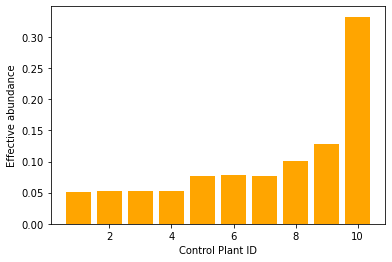

In [37]:
plt.bar([i + 1 for i in range(c_p)], mean_sigma_c, color='orange')
plt.xlabel('Control Plant ID')
plt.ylabel('Effective abundance')

Text(0, 0.5, 'Effective abundance')

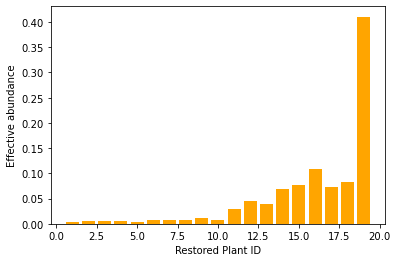

In [38]:
plt.bar([i + 1 for i in range(r_p)], mean_sigma_r, color='orange')
plt.xlabel('Restored Plant ID')
plt.ylabel('Effective abundance')

We can do the same with the pollinators:

In [39]:
mean_tau_c = np.mean(samples_c['tau'], axis=1)
mean_tau_r = np.mean(samples_r['tau'], axis=1)

Text(0, 0.5, 'Effective abundance')

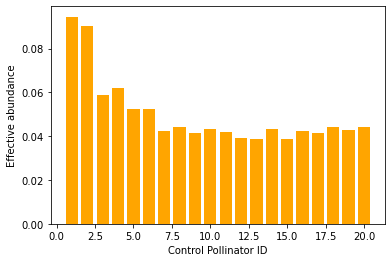

In [40]:
plt.bar([i + 1 for i in range(c_a)], mean_tau_c, color='orange')
plt.xlabel('Control Pollinator ID')
plt.ylabel('Effective abundance')

Text(0, 0.5, 'Effective abundance')

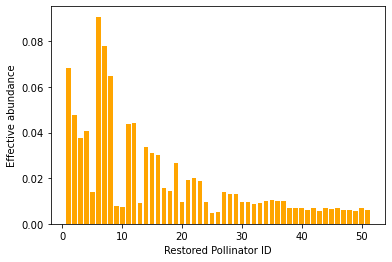

In [41]:
plt.bar([i + 1 for i in range(r_a)], mean_tau_r, color='orange')
plt.xlabel('Restored Pollinator ID')
plt.ylabel('Effective abundance')

The last thing we'll calculate is the posterior distribution of **some arbitrary function** of the incidence matrix.

To make this example simple, we'll consider the number of non-zero entries, i.e.,

$$f(B) = \sum_{ij} B_{ij}$$

The python definition of this function is simple:

In [44]:
def nodfc(B):
    #mask = B == 0
    #rows = np.where((~mask).sum(axis=1) == 0)
    #cols = np.where((~mask).sum(axis=0) == 0)
    #B = np.delete(B, rows, axis=0)
    #B = np.delete(B, cols, axis=1)
    
    if np.all(B.sum(axis=1) != 0) & np.all(B.sum(axis=0) != 0):
        #return NestednessCalculator(B).nodf(B)
        
        nodf = toolbox.nodf(B)
        maxnodf = toolbox.nodf(greedySolver2.greedySolve(B.shape[0], B.shape[1], B.sum()))
        C = B.sum()
        S = B.shape[0] + B.shape[1]
        nodfc = (nodf/maxnodf) / (C * np.log(S))
        return nodfc

Again, we provide a simpler interface to make the calculation:

In [ ]:
posterior_values_nodf_c = pp.get_network_property_distribution(samples_c, nodfc)
posterior_values_nodf_r = pp.get_network_property_distribution(samples_r, nodfc)

100%|█████████████████████████████████████████| 44/44 [00:00<00:00, 1281.82it/s]


100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 1627.31it/s]


100%|█████████████████████████████████████████| 17/17 [00:00<00:00, 1780.53it/s]


100%|█████████████████████████████████████████| 34/34 [00:00<00:00, 1548.97it/s]


100%|█████████████████████████████████████████| 33/33 [00:00<00:00, 1570.54it/s]


100%|█████████████████████████████████████████| 31/31 [00:00<00:00, 1569.78it/s]


100%|█████████████████████████████████████████| 22/22 [00:00<00:00, 1943.48it/s]


100%|█████████████████████████████████████████| 36/36 [00:00<00:00, 1541.36it/s]


100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 1664.16it/s]


100%|█████████████████████████████████████████| 47/47 [00:00<00:00, 1421.48it/s]


100%|█████████████████████████████████████████| 36/36 [00:00<00:00, 1551.58it/s]


100%|█████████████████████████████████████████| 43/43 [00:00<00:00, 1508.09it/s]


100%|█████████████████████████████████████████| 53/53 [00:00<00:00, 1398.72it/s]


100%|█████████████████████████████████████████| 37/37 [00:00<00:00, 1563.82it/s]


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 1363.65it/s]


100%|█████████████████████████████████████████| 43/43 [00:00<00:00, 1453.89it/s]


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 1802.18it/s]


100%|█████████████████████████████████████████| 86/86 [00:00<00:00, 1202.17it/s]


100%|█████████████████████████████████████████| 78/78 [00:00<00:00, 1231.08it/s]


100%|█████████████████████████████████████████| 44/44 [00:00<00:00, 1465.11it/s]


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 1896.76it/s]


100%|█████████████████████████████████████████| 45/45 [00:00<00:00, 1470.87it/s]


100%|█████████████████████████████████████████| 13/13 [00:00<00:00, 2009.88it/s]


100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 1686.33it/s]


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 1405.46it/s]


100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 1535.44it/s]


100%|█████████████████████████████████████████| 48/48 [00:00<00:00, 1419.90it/s]


100%|█████████████████████████████████████████| 41/41 [00:00<00:00, 1525.86it/s]


100%|█████████████████████████████████████████| 27/27 [00:00<00:00, 1424.80it/s]


100%|█████████████████████████████████████████| 38/38 [00:00<00:00, 1537.15it/s]


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 1360.04it/s]


100%|█████████████████████████████████████████| 33/33 [00:00<00:00, 1564.65it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████| 42/42 [00:00<00:00, 1382.49it/s]


100%|█████████████████████████████████████████| 21/21 [00:00<00:00, 1717.23it/s]


100%|█████████████████████████████████████████| 33/33 [00:00<00:00, 1479.17it/s]


100%|█████████████████████████████████████████| 23/23 [00:00<00:00, 1626.00it/s]


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 1483.52it/s]


100%|█████████████████████████████████████████| 19/19 [00:00<00:00, 1827.08it/s]


100%|█████████████████████████████████████████| 48/48 [00:00<00:00, 1379.11it/s]


100%|█████████████████████████████████████████| 43/43 [00:00<00:00, 1252.18it/s]


100%|█████████████████████████████████████████| 44/44 [00:00<00:00, 1356.76it/s]


100%|█████████████████████████████████████████| 34/34 [00:00<00:00, 1558.06it/s]


100%|█████████████████████████████████████████| 33/33 [00:00<00:00, 1564.93it/s]


100%|█████████████████████████████████████████| 41/41 [00:00<00:00, 1531.04it/s]


100%|█████████████████████████████████████████| 38/38 [00:00<00:00, 1501.07it/s]


100%|█████████████████████████████████████████| 28/28 [00:00<00:00, 1098.59it/s]


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 1833.01it/s]


100%|█████████████████████████████████████████| 24/24 [00:00<00:00, 1598.29it/s]


100%|█████████████████████████████████████████| 34/34 [00:00<00:00, 1552.43it/s]


100%|█████████████████████████████████████████| 18/18 [00:00<00:00, 1494.53it/s]


100%|█████████████████████████████████████████| 42/42 [00:00<00:00, 1308.95it/s]


100%|█████████████████████████████████████████| 69/69 [00:00<00:00, 1273.51it/s]


100%|█████████████████████████████████████████| 22/22 [00:00<00:00, 1658.13it/s]


100%|█████████████████████████████████████████| 26/26 [00:00<00:00, 1614.89it/s]


100%|█████████████████████████████████████████| 43/43 [00:00<00:00, 1322.83it/s]


100%|█████████████████████████████████████████| 24/24 [00:00<00:00, 1786.52it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████| 47/47 [00:00<00:00, 1431.40it/s]


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 1359.13it/s]


100%|█████████████████████████████████████████| 38/38 [00:00<00:00, 1019.83it/s]


100%|█████████████████████████████████████████| 54/54 [00:00<00:00, 1365.43it/s]


100%|█████████████████████████████████████████| 64/64 [00:00<00:00, 1251.37it/s]


100%|█████████████████████████████████████████| 46/46 [00:00<00:00, 1335.74it/s]


100%|█████████████████████████████████████████| 23/23 [00:00<00:00, 1666.76it/s]


100%|█████████████████████████████████████████| 24/24 [00:00<00:00, 1654.61it/s]


100%|█████████████████████████████████████████| 28/28 [00:00<00:00, 1619.15it/s]


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 1485.28it/s]


100%|█████████████████████████████████████████| 16/16 [00:00<00:00, 1739.47it/s]


100%|█████████████████████████████████████████| 51/51 [00:00<00:00, 1334.02it/s]


100%|██████████████████████████████████████████| 52/52 [00:00<00:00, 900.79it/s]


100%|█████████████████████████████████████████| 44/44 [00:00<00:00, 1394.84it/s]


100%|█████████████████████████████████████████| 26/26 [00:00<00:00, 1596.66it/s]


100%|█████████████████████████████████████████| 50/50 [00:00<00:00, 1389.58it/s]


100%|█████████████████████████████████████████| 30/30 [00:00<00:00, 1663.99it/s]


100%|█████████████████████████████████████████| 43/43 [00:00<00:00, 1465.57it/s]


100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 1341.19it/s]


100%|█████████████████████████████████████████| 37/37 [00:00<00:00, 1502.80it/s]


100%|█████████████████████████████████████████| 24/24 [00:00<00:00, 1683.14it/s]


100%|█████████████████████████████████████████| 27/27 [00:00<00:00, 1623.49it/s]


100%|█████████████████████████████████████████| 46/46 [00:00<00:00, 1410.57it/s]


100%|█████████████████████████████████████████| 42/42 [00:00<00:00, 1474.40it/s]


100%|█████████████████████████████████████████| 53/53 [00:00<00:00, 1367.74it/s]


100%|█████████████████████████████████████████| 45/45 [00:00<00:00, 1398.77it/s]


100%|█████████████████████████████████████████| 24/24 [00:00<00:00, 1411.25it/s]


100%|█████████████████████████████████████████| 46/46 [00:00<00:00, 1396.34it/s]


100%|█████████████████████████████████████████| 32/32 [00:00<00:00, 1521.35it/s]


100%|█████████████████████████████████████████| 41/41 [00:00<00:00, 1463.61it/s]


100%|█████████████████████████████████████████| 30/30 [00:00<00:00, 1613.77it/s]


100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 1311.79it/s]


100%|█████████████████████████████████████████| 67/67 [00:00<00:00, 1121.19it/s]


100%|█████████████████████████████████████████| 25/25 [00:00<00:00, 1622.96it/s]


100%|█████████████████████████████████████████| 42/42 [00:00<00:00, 1412.77it/s]


100%|█████████████████████████████████████████| 43/43 [00:00<00:00, 1456.65it/s]


100%|█████████████████████████████████████████| 52/52 [00:00<00:00, 1364.87it/s]


100%|█████████████████████████████████████████| 27/27 [00:00<00:00, 1346.36it/s]


100%|█████████████████████████████████████████| 17/17 [00:00<00:00, 1822.26it/s]


100%|█████████████████████████████████████████| 17/17 [00:00<00:00, 1350.69it/s]


100%|█████████████████████████████████████████| 14/14 [00:00<00:00, 1904.21it/s]


100%|█████████████████████████████████████████| 47/47 [00:00<00:00, 1297.84it/s]


100%|█████████████████████████████████████████| 46/46 [00:00<00:00, 1382.67it/s]


100%|█████████████████████████████████████████| 38/38 [00:00<00:00, 1421.42it/s]


100%|█████████████████████████████████████████| 52/52 [00:00<00:00, 1376.79it/s]


100%|█████████████████████████████████████████| 22/22 [00:00<00:00, 1721.29it/s]


100%|█████████████████████████████████████████| 50/50 [00:00<00:00, 1212.74it/s]


100%|█████████████████████████████████████████| 53/53 [00:00<00:00, 1251.21it/s]


100%|█████████████████████████████████████████| 32/32 [00:00<00:00, 1561.27it/s]


100%|█████████████████████████████████████████| 17/17 [00:00<00:00, 1627.70it/s]


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 1663.91it/s]


100%|█████████████████████████████████████████| 36/36 [00:00<00:00, 1285.38it/s]


100%|█████████████████████████████████████████| 42/42 [00:00<00:00, 1373.36it/s]


100%|█████████████████████████████████████████| 46/46 [00:00<00:00, 1425.60it/s]


100%|█████████████████████████████████████████| 50/50 [00:00<00:00, 1351.94it/s]


100%|█████████████████████████████████████████| 26/26 [00:00<00:00, 1608.41it/s]


100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 1639.81it/s]


100%|█████████████████████████████████████████| 40/40 [00:00<00:00, 1453.48it/s]


100%|█████████████████████████████████████████| 23/23 [00:00<00:00, 1530.45it/s]


100%|█████████████████████████████████████████| 30/30 [00:00<00:00, 1554.81it/s]


100%|█████████████████████████████████████████| 41/41 [00:00<00:00, 1438.54it/s]


100%|█████████████████████████████████████████| 18/18 [00:00<00:00, 1694.74it/s]


100%|█████████████████████████████████████████| 25/25 [00:00<00:00, 1394.77it/s]


100%|█████████████████████████████████████████| 25/25 [00:00<00:00, 1399.16it/s]


100%|█████████████████████████████████████████| 42/42 [00:00<00:00, 1389.86it/s]


100%|█████████████████████████████████████████| 48/48 [00:00<00:00, 1268.33it/s]


100%|█████████████████████████████████████████| 38/38 [00:00<00:00, 1251.81it/s]


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 1219.89it/s]


100%|█████████████████████████████████████████| 54/54 [00:00<00:00, 1361.89it/s]


100%|█████████████████████████████████████████| 28/28 [00:00<00:00, 1613.17it/s]


100%|█████████████████████████████████████████| 47/47 [00:00<00:00, 1302.85it/s]


100%|█████████████████████████████████████████| 19/19 [00:00<00:00, 1885.48it/s]


100%|█████████████████████████████████████████| 33/33 [00:00<00:00, 1605.52it/s]


100%|█████████████████████████████████████████| 11/11 [00:00<00:00, 2073.12it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████| 48/48 [00:00<00:00, 1426.54it/s]


100%|█████████████████████████████████████████| 38/38 [00:00<00:00, 1302.88it/s]


100%|█████████████████████████████████████████| 43/43 [00:00<00:00, 1407.89it/s]


100%|█████████████████████████████████████████| 51/51 [00:00<00:00, 1372.45it/s]


100%|█████████████████████████████████████████| 41/41 [00:00<00:00, 1529.62it/s]


100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 1529.84it/s]


100%|█████████████████████████████████████████| 42/42 [00:00<00:00, 1466.08it/s]


100%|█████████████████████████████████████████| 59/59 [00:00<00:00, 1323.46it/s]


100%|█████████████████████████████████████████| 17/17 [00:00<00:00, 1864.67it/s]


100%|█████████████████████████████████████████| 36/36 [00:00<00:00, 1446.94it/s]


100%|█████████████████████████████████████████| 43/43 [00:00<00:00, 1530.31it/s]


100%|█████████████████████████████████████████| 19/19 [00:00<00:00, 1676.35it/s]


100%|█████████████████████████████████████████| 41/41 [00:00<00:00, 1513.76it/s]


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 898.99it/s]


100%|█████████████████████████████████████████| 34/34 [00:00<00:00, 1486.46it/s]


100%|█████████████████████████████████████████| 47/47 [00:00<00:00, 1232.07it/s]


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 1470.91it/s]


100%|█████████████████████████████████████████| 26/26 [00:00<00:00, 1626.94it/s]


100%|█████████████████████████████████████████| 38/38 [00:00<00:00, 1508.90it/s]


100%|█████████████████████████████████████████| 27/27 [00:00<00:00, 1589.09it/s]


100%|█████████████████████████████████████████| 37/37 [00:00<00:00, 1372.41it/s]


100%|█████████████████████████████████████████| 12/12 [00:00<00:00, 1906.00it/s]


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 1243.58it/s]


100%|█████████████████████████████████████████| 46/46 [00:00<00:00, 1342.72it/s]


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 1315.89it/s]


100%|█████████████████████████████████████████| 40/40 [00:00<00:00, 1475.37it/s]


100%|█████████████████████████████████████████| 60/60 [00:00<00:00, 1229.39it/s]


100%|█████████████████████████████████████████| 32/32 [00:00<00:00, 1465.53it/s]


100%|█████████████████████████████████████████| 41/41 [00:00<00:00, 1427.38it/s]


100%|█████████████████████████████████████████| 72/72 [00:00<00:00, 1240.78it/s]


100%|█████████████████████████████████████████| 27/27 [00:00<00:00, 1593.67it/s]


100%|█████████████████████████████████████████| 36/36 [00:00<00:00, 1494.51it/s]


100%|█████████████████████████████████████████| 12/12 [00:00<00:00, 1884.16it/s]


100%|█████████████████████████████████████████| 65/65 [00:00<00:00, 1253.98it/s]


100%|█████████████████████████████████████████| 38/38 [00:00<00:00, 1373.83it/s]


100%|█████████████████████████████████████████| 66/66 [00:00<00:00, 1178.99it/s]


100%|█████████████████████████████████████████| 59/59 [00:00<00:00, 1312.53it/s]


100%|█████████████████████████████████████████| 27/27 [00:00<00:00, 1714.81it/s]


100%|█████████████████████████████████████████| 52/52 [00:00<00:00, 1360.93it/s]


100%|█████████████████████████████████████████| 71/71 [00:00<00:00, 1235.57it/s]


100%|█████████████████████████████████████████| 21/21 [00:00<00:00, 1692.45it/s]


100%|█████████████████████████████████████████| 30/30 [00:00<00:00, 1465.14it/s]


100%|█████████████████████████████████████████| 53/53 [00:00<00:00, 1325.96it/s]


100%|█████████████████████████████████████████| 22/22 [00:00<00:00, 1468.34it/s]


100%|█████████████████████████████████████████| 46/46 [00:00<00:00, 1432.34it/s]


100%|█████████████████████████████████████████| 27/27 [00:00<00:00, 1573.72it/s]


100%|█████████████████████████████████████████| 41/41 [00:00<00:00, 1458.11it/s]


100%|█████████████████████████████████████████| 40/40 [00:00<00:00, 1374.91it/s]


100%|█████████████████████████████████████████| 34/34 [00:00<00:00, 1581.98it/s]


100%|█████████████████████████████████████████| 24/24 [00:00<00:00, 1786.27it/s]


100%|█████████████████████████████████████████| 23/23 [00:00<00:00, 1799.46it/s]


100%|█████████████████████████████████████████| 57/57 [00:00<00:00, 1330.87it/s]


100%|███████████████████████████████████████████| 25/25 [04:58<00:00, 11.95s/it]


100%|█████████████████████████████████████████| 13/13 [00:00<00:00, 1895.63it/s]


100%|█████████████████████████████████████████| 36/36 [00:00<00:00, 1605.07it/s]


100%|█████████████████████████████████████████| 32/32 [00:00<00:00, 1678.04it/s]


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 1383.62it/s]


100%|█████████████████████████████████████████| 41/41 [00:00<00:00, 1579.91it/s]


100%|█████████████████████████████████████████| 16/16 [00:00<00:00, 1905.64it/s]


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 1439.15it/s]


100%|█████████████████████████████████████████| 27/27 [00:00<00:00, 1720.10it/s]


100%|█████████████████████████████████████████| 37/37 [00:00<00:00, 1608.50it/s]


100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 1392.00it/s]


100%|█████████████████████████████████████████| 58/58 [00:00<00:00, 1377.21it/s]


100%|█████████████████████████████████████████| 60/60 [00:00<00:00, 1347.86it/s]


100%|█████████████████████████████████████████| 13/13 [00:00<00:00, 2097.23it/s]


100%|█████████████████████████████████████████| 40/40 [00:00<00:00, 1582.67it/s]


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 1429.35it/s]


100%|█████████████████████████████████████████| 57/57 [00:00<00:00, 1377.92it/s]


100%|█████████████████████████████████████████| 64/64 [00:00<00:00, 1329.71it/s]


100%|█████████████████████████████████████████| 24/24 [00:00<00:00, 1840.25it/s]


100%|█████████████████████████████████████████| 58/58 [00:00<00:00, 1382.31it/s]


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 1572.97it/s]


100%|█████████████████████████████████████████| 36/36 [00:00<00:00, 1622.35it/s]


100%|█████████████████████████████████████████| 84/84 [00:00<00:00, 1212.23it/s]


100%|█████████████████████████████████████████| 24/24 [00:00<00:00, 1883.25it/s]


100%|█████████████████████████████████████████| 24/24 [00:00<00:00, 1839.20it/s]


100%|█████████████████████████████████████████| 61/61 [00:00<00:00, 1327.91it/s]


100%|█████████████████████████████████████████| 42/42 [00:00<00:00, 1537.01it/s]


100%|█████████████████████████████████████████| 53/53 [00:00<00:00, 1418.25it/s]


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 1434.92it/s]


100%|██████████████████████████████████████████| 45/45 [00:00<00:00, 919.68it/s]


100%|█████████████████████████████████████████| 21/21 [00:00<00:00, 1913.96it/s]


100%|█████████████████████████████████████████| 27/27 [00:00<00:00, 1790.09it/s]


100%|█████████████████████████████████████████| 60/60 [00:00<00:00, 1412.70it/s]


100%|█████████████████████████████████████████| 50/50 [00:00<00:00, 1465.46it/s]


100%|█████████████████████████████████████████| 24/24 [00:00<00:00, 1762.87it/s]


100%|█████████████████████████████████████████| 21/21 [00:00<00:00, 1790.29it/s]


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 1410.71it/s]


100%|█████████████████████████████████████████| 40/40 [00:00<00:00, 1678.48it/s]


100%|█████████████████████████████████████████| 35/35 [00:00<00:00, 1659.46it/s]


100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 2340.14it/s]


100%|█████████████████████████████████████████| 33/33 [00:00<00:00, 1665.91it/s]


100%|█████████████████████████████████████████| 41/41 [00:00<00:00, 1544.43it/s]


100%|█████████████████████████████████████████| 62/62 [00:00<00:00, 1331.24it/s]


100%|█████████████████████████████████████████| 36/36 [00:00<00:00, 1629.49it/s]


100%|█████████████████████████████████████████| 43/43 [00:00<00:00, 1524.71it/s]


100%|█████████████████████████████████████████| 34/34 [00:00<00:00, 1663.40it/s]


100%|█████████████████████████████████████████| 28/28 [00:00<00:00, 1740.97it/s]


100%|█████████████████████████████████████████| 41/41 [00:00<00:00, 1565.42it/s]


100%|█████████████████████████████████████████| 57/57 [00:00<00:00, 1371.84it/s]


100%|█████████████████████████████████████████| 28/28 [00:00<00:00, 1798.34it/s]


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 1931.70it/s]


100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 1743.32it/s]


100%|█████████████████████████████████████████| 38/38 [00:00<00:00, 1487.45it/s]


100%|█████████████████████████████████████████| 44/44 [00:00<00:00, 1484.69it/s]


100%|█████████████████████████████████████████| 63/63 [00:00<00:00, 1380.55it/s]


100%|█████████████████████████████████████████| 31/31 [00:00<00:00, 1751.82it/s]


100%|█████████████████████████████████████████| 24/24 [00:00<00:00, 1702.00it/s]


100%|█████████████████████████████████████████| 34/34 [00:00<00:00, 1629.84it/s]


100%|█████████████████████████████████████████| 31/31 [00:00<00:00, 1707.89it/s]


100%|█████████████████████████████████████████| 32/32 [00:00<00:00, 1672.66it/s]


100%|█████████████████████████████████████████| 62/62 [00:00<00:00, 1264.71it/s]


100%|█████████████████████████████████████████| 52/52 [00:00<00:00, 1412.96it/s]


100%|█████████████████████████████████████████| 53/53 [00:00<00:00, 1410.56it/s]


100%|█████████████████████████████████████████| 59/59 [00:00<00:00, 1360.51it/s]


100%|█████████████████████████████████████████| 35/35 [00:00<00:00, 1555.14it/s]


100%|█████████████████████████████████████████| 24/24 [00:00<00:00, 1900.38it/s]


100%|█████████████████████████████████████████| 36/36 [00:00<00:00, 1619.28it/s]


100%|█████████████████████████████████████████| 35/35 [00:00<00:00, 1599.34it/s]


100%|█████████████████████████████████████████| 59/59 [00:00<00:00, 1361.67it/s]


100%|█████████████████████████████████████████| 33/33 [00:00<00:00, 1655.13it/s]


100%|█████████████████████████████████████████| 60/60 [00:00<00:00, 1336.36it/s]


100%|█████████████████████████████████████████| 43/43 [00:00<00:00, 1533.75it/s]


100%|█████████████████████████████████████████| 35/35 [00:00<00:00, 1651.41it/s]


100%|█████████████████████████████████████████| 41/41 [00:00<00:00, 1560.79it/s]


100%|█████████████████████████████████████████| 19/19 [00:00<00:00, 1940.96it/s]


100%|█████████████████████████████████████████| 54/54 [00:00<00:00, 1412.54it/s]


100%|█████████████████████████████████████████| 53/53 [00:00<00:00, 1403.75it/s]


100%|█████████████████████████████████████████| 28/28 [00:00<00:00, 1781.89it/s]


100%|█████████████████████████████████████████| 44/44 [00:00<00:00, 1525.87it/s]


100%|█████████████████████████████████████████| 52/52 [00:00<00:00, 1422.33it/s]


100%|█████████████████████████████████████████| 37/37 [00:00<00:00, 1596.56it/s]


100%|█████████████████████████████████████████| 31/31 [00:00<00:00, 1713.45it/s]


100%|█████████████████████████████████████████| 30/30 [00:00<00:00, 1754.38it/s]


100%|█████████████████████████████████████████| 27/27 [00:00<00:00, 1805.67it/s]


100%|█████████████████████████████████████████| 35/35 [00:00<00:00, 1641.72it/s]


100%|█████████████████████████████████████████| 44/44 [00:00<00:00, 1526.50it/s]


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 1585.49it/s]


100%|█████████████████████████████████████████| 33/33 [00:00<00:00, 1659.62it/s]


100%|█████████████████████████████████████████| 63/63 [00:00<00:00, 1319.01it/s]


100%|█████████████████████████████████████████| 50/50 [00:00<00:00, 1449.74it/s]


100%|█████████████████████████████████████████| 32/32 [00:00<00:00, 1730.48it/s]


100%|█████████████████████████████████████████| 34/34 [00:00<00:00, 1088.17it/s]


100%|█████████████████████████████████████████| 51/51 [00:00<00:00, 1435.25it/s]


100%|█████████████████████████████████████████| 34/34 [00:00<00:00, 1659.27it/s]


100%|█████████████████████████████████████████| 44/44 [00:00<00:00, 1523.54it/s]


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 1566.46it/s]


100%|█████████████████████████████████████████| 33/33 [00:00<00:00, 1676.66it/s]


100%|█████████████████████████████████████████| 36/36 [00:00<00:00, 1622.00it/s]


100%|█████████████████████████████████████████| 31/31 [00:00<00:00, 1700.41it/s]


100%|█████████████████████████████████████████| 11/11 [00:00<00:00, 2224.88it/s]


100%|█████████████████████████████████████████| 38/38 [00:00<00:00, 1594.17it/s]


100%|█████████████████████████████████████████| 34/34 [00:00<00:00, 1652.74it/s]


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 1947.22it/s]


100%|█████████████████████████████████████████| 31/31 [00:00<00:00, 1697.50it/s]


100%|██████████████████████████████████████████| 28/28 [00:00<00:00, 840.69it/s]


100%|█████████████████████████████████████████| 22/22 [00:00<00:00, 1901.43it/s]


100%|█████████████████████████████████████████| 46/46 [00:00<00:00, 1501.16it/s]


100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 1380.61it/s]


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 1614.31it/s]


100%|█████████████████████████████████████████| 53/53 [00:00<00:00, 1410.29it/s]


100%|█████████████████████████████████████████| 40/40 [00:00<00:00, 1567.03it/s]


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 1452.50it/s]


100%|█████████████████████████████████████████| 40/40 [00:00<00:00, 1577.73it/s]


100%|█████████████████████████████████████████| 45/45 [00:00<00:00, 1500.80it/s]


100%|█████████████████████████████████████████| 57/57 [00:00<00:00, 1369.53it/s]


100%|█████████████████████████████████████████| 36/36 [00:00<00:00, 1633.42it/s]


100%|█████████████████████████████████████████| 38/38 [00:00<00:00, 1378.71it/s]


100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 1752.79it/s]


100%|█████████████████████████████████████████| 42/42 [00:00<00:00, 1556.82it/s]


100%|█████████████████████████████████████████| 46/46 [00:00<00:00, 1494.23it/s]


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 1581.30it/s]


100%|█████████████████████████████████████████| 28/28 [00:00<00:00, 1794.77it/s]


100%|█████████████████████████████████████████| 35/35 [00:00<00:00, 1565.99it/s]


100%|█████████████████████████████████████████| 45/45 [00:00<00:00, 1511.85it/s]


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 1595.60it/s]


100%|█████████████████████████████████████████| 30/30 [00:00<00:00, 1704.47it/s]


100%|█████████████████████████████████████████| 30/30 [00:00<00:00, 1723.73it/s]


100%|█████████████████████████████████████████| 25/25 [00:00<00:00, 1875.61it/s]


100%|█████████████████████████████████████████| 40/40 [00:00<00:00, 1598.87it/s]


100%|█████████████████████████████████████████| 40/40 [00:00<00:00, 1576.54it/s]


100%|█████████████████████████████████████████| 38/38 [00:00<00:00, 1590.96it/s]


100%|█████████████████████████████████████████| 48/48 [00:00<00:00, 1455.29it/s]


100%|█████████████████████████████████████████| 29/29 [00:00<00:00, 1774.01it/s]


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 2127.68it/s]


100%|█████████████████████████████████████████| 30/30 [00:00<00:00, 1743.80it/s]


100%|█████████████████████████████████████████| 35/35 [00:00<00:00, 1624.28it/s]


100%|█████████████████████████████████████████| 54/54 [00:00<00:00, 1402.13it/s]


100%|█████████████████████████████████████████| 34/34 [00:00<00:00, 1656.36it/s]


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 1151.37it/s]


100%|█████████████████████████████████████████| 32/32 [00:00<00:00, 1564.55it/s]


100%|█████████████████████████████████████████| 37/37 [00:00<00:00, 1616.57it/s]


100%|█████████████████████████████████████████| 34/34 [00:00<00:00, 1667.48it/s]


100%|█████████████████████████████████████████| 78/78 [00:00<00:00, 1243.56it/s]


100%|█████████████████████████████████████████| 53/53 [00:00<00:00, 1427.70it/s]


We find, in this case:

In [ ]:
# control

plt.figure(figsize=(4,4))
plt.hist(posterior_values_nodf_c, density=False, bins=20, rwidth=0.9);

plt.xlabel('NODF')
plt.ylabel('Count')
plt.xlim(0, 1)

In [ ]:
# restored

plt.figure(figsize=(4,4))
plt.hist(posterior_values_nodf_r, density=False, bins=20, rwidth=0.9);

plt.xlabel('NODF')
plt.ylabel('Count')
plt.xlim(0, 1)

# Further information: 

"*[Reconstruction of plant–pollinator networks from observational data](https://www.biorxiv.org/content/10.1101/754077v1)*"<br/>
[J.-G. Young](http://jgyoung.ca), [F. S. Valdovinos](https://www.fsvaldovinos.com/) and [M.E.J. Newman](http://www-personal.umich.edu/~mejn/)<br/>
bioRxiv:754077 (2019)


Or get in touch at <jgyou@umich.edu> and on [github](https://github.com/jg-you/plant-pol-inference)!